In [52]:
%run paper/setup.py

In [2]:
from exoplanet.utils import eval_in_model
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano

class SyntheticBinary(object):
    """
    This class makes a synthetic light curve and injects a time delay signal corresponding to the input binary orbit parameters    
    """
    def __init__(self, time, freq, amplitude, 
                 period, eccen, asini, varpi, tref):
        self.time = time
        self.freq = freq
        self.amplitude = amplitude
        self.period, self.eccen, self.asini, self.varpi, self.tref = period, eccen, asini, varpi, tref
        
        self.make_lightcurve()
        self.flux = self.flux_true
        
    def make_lightcurve(self):
        self.flux_true = np.zeros(len(self.time))
        
        with pm.Model() as model:
            #M = tt.zeros_like(tt.constant(self.time) - self.tref) + 2.0 * np.pi * (tt.constant(self.time)) / self.period
            M = 2.0 * np.pi * (tt.constant(self.time) - self.tref) / self.period
            f = get_true_anomaly(M, self.eccen + tt.zeros_like(M))
            tau_tens = ((1 - tt.square(self.eccen)) * tt.sin(f+self.varpi) / (1 + self.eccen*tt.cos(f))) * (self.asini / 86400.)
            self.tau = eval_in_model(tau_tens)
            
        for j, A_j in zip(self.freq, self.amplitude):
            omega = 2 * np.pi * j
            self.flux_true += A_j * np.sin(omega * (self.time - self.tau))# + A_j * np.sin(omega * (self.time - self.tau))
            
    def add_noise(self, snr=5):
        # Add noise
        s_rms = self.amplitude / (np.sqrt(np.pi / len(self.time)) * snr)
        #print(s_rms, self.amplitude)
        #print(np.random.normal(loc=0.0, scale=s_rms, size=len(self.time)))
        self.flux = self.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(self.time))
        #self.flux_err = noise * np.std(self.flux_true)
        #self.flux = self.flux_true + self.flux_err * np.random.randn(len(self.flux_true))

In [3]:
snrs = np.geomspace(1,1000,51)
eccens = [0.,0.8,0.95,0.99]

# Fixed parameters
period_t = 10
asini_t = 100
varpi_t = 0.
tref_t = 0.
freqs = np.array([50])
amps = np.array([0.1])
eccen_t = 0.9

time = np.arange(0, 3*period_t, 1.0 / (24 * 30))

In [4]:

lc = SyntheticBinary(time, freqs, amps, period_t, eccen_t, asini_t, varpi_t, tref_t)
lc.add_noise(snr=50)

# ms = Maelstrom(lc.time, lc.flux, freq=freqs)
# a, b = ms.get_time_delay(segment_size=2.)
# a += ms.time_mid

time_tensor = theano.shared(lc.time)
flux_tensor = theano.shared(lc.flux)

# td_time_tensor = theano.shared(a)
# td_td_tensor = theano.shared(b[:,0])

with pm.Model() as fit_model:
    period = pm.Flat("period", testval=9)#pm.Uniform("period", lower=1, upper=100, testval=period_t)
    asini = pm.Flat("asini", testval=asini_t)#asini_t#pm.Uniform("asini", lower=0, upper=1000, testval=asini_t)
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux_tensor.get_value())), sd=10, testval=0.)
    eccen = pm.Flat('eccen', testval=eccen_t)#pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=eccen_t)
    omega, phi = 0., 0.
    
    M = 2.0 * np.pi * time_tensor / period - phi
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    psi = (1 - tt.square(eccen)) * tt.sin(f+omega) / (1 + eccen*tt.cos(f))

    # Positive
    arg = 2. * np.pi * freqs * (time_tensor[:, None] - ((asini) / 86400) * psi[:, None])
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    DT = D.T
    w = tt.slinalg.solve(tt.dot(DT, D), tt.dot(DT, flux_tensor))
    lc_model = tt.dot(D, w)

    pm.Normal('obs', mu=lc_model, 
              sd=tt.exp(logs_lc), 
              observed=flux_tensor)
    
    fit_params = [v for v in fit_model.vars if v.name not in ["period", "eccen"]]
    
# with pm.Model() as subdivide_model:
#     period = pm.Flat("period", testval=period_t)#pm.Uniform("period", lower=1, upper=100, testval=period_t)
#     asini = pm.Flat("asini", testval=asini_t)#asini_t#pm.Uniform("asini", lower=0, upper=1000, testval=asini_t)
#     logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux_tensor.get_value())), sd=10, testval=0.)
#     eccen = pm.Flat('eccen', testval=eccen_t)#pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=eccen_t)
#     omega, phi = 0., 0.
    
#     M = 2.0 * np.pi * td_time_tensor / period - phi
#     f = get_true_anomaly(M, eccen + tt.zeros_like(M))
#     psi = (1 - tt.square(eccen)) * tt.sin(f+omega) / (1 + eccen*tt.cos(f))

#     tau = (asini) * psi

#     pm.Normal('obs', mu=tau, 
#               sd=tt.exp(logs_lc), 
#               observed=td_td_tensor)
    
#     fit_params_subdivide = [v for v in subdivide_model.vars if v.name not in ["period", "eccen"]]

In [5]:
def run_fit(time, flux, period, asini, eccen):
    with fit_model:
        time_tensor.set_value(time)
        flux_tensor.set_value(flux)
        
        start = dict(fit_model.test_point)
        start['period'] = period
        start['asini'] = asini
        start['eccen'] = eccen
        
        return xo.optimize(start, vars=fit_params, verbose=False)
    
# def run_fit_subdivide(td_time, td_td, period, asini, eccen):
#     with subdivide_model:
#         td_time_tensor.set_value(td_time)
#         td_td_tensor.set_value(td_td)
        
#         start = dict(subdivide_model.test_point)
#         start['period'] = period
#         start['asini'] = asini
#         start['eccen'] = eccen
        
#         return xo.optimize(start, vars=fit_params_subdivide, verbose=False)

In [6]:
lc = SyntheticBinary(time, freqs, amps, period_t, eccen_t, asini_t, varpi_t, tref_t)
lc.add_noise(snr=50000)

opt = run_fit(lc.time, lc.flux, period_t, asini_t, eccen_t)
# opt_subd = run_fit_subdivide(a, b[:,0], period_t, asini_t, eccen_t)

In [7]:
opt

{'period': array(10.),
 'asini': array(100.00382711),
 'logs_lc': array(-8.70217056),
 'eccen': array(0.9)}

In [20]:
from tqdm import tqdm
snr=5
eccen_t = 0.5
lc = SyntheticBinary(time, freqs, amps,
     period_t, eccen_t, asini_t, varpi_t, tref_t)
s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
asini_x = []
for i in tqdm(range(100)):
    noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))
    # Run the fit
    opt = run_fit(lc.time, noisy_flux, period_t, asini_t, eccen_t)
    asini_x.append(opt['asini'])

100%|██████████| 100/100 [02:39<00:00,  2.14s/it]


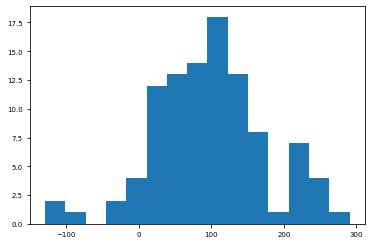

In [21]:
plt.hist(asini_x, bins=15);

In [22]:
np.median(asini_x)

95.4963459709348

## FITTING

In [21]:
snrs = np.geomspace(1,1000,51)
# eccens = [0.,0.8,0.99]
eccens = [0.,0.5,0.99]

In [22]:
from tqdm import tqdm

asinis_all_maelstrom = []
uncertainties_all_maelstrom = []

for eccen in eccens:
    eccen_t = eccen
    lc = SyntheticBinary(time, freqs, amps,
         period_t, eccen_t, asini_t, varpi_t, tref_t)
    
    uncertainties = []
    asinis = []
    # Iterate over each SNR for the given eccentricity
    for snr in tqdm(snrs):
        s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
        asini_x = []
#         for i in range(100):
        noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))
        # Run the fit
        opt = run_fit(lc.time, noisy_flux, period_t, asini_t, eccen_t)
#         asini_x.append(opt['asini'])
        asinis.append(opt['asini'])
        
#         # Get Hessian estimate
#         with fit_model:
#             hess = pm.find_hessian(opt, vars=[asini])
#         uncertainties.append(1/np.sqrt(np.abs(np.diag(hess)))[0])
    asinis_all_maelstrom.append(asinis)
#     uncertainties_all_maelstrom.append(uncertainties)

asinis_all_maelstrom = np.array(asinis_all_maelstrom)
#uncertainties_all_maelstrom = np.array(uncertainties_all)

100%|██████████| 51/51 [1:47:17<00:00, 110.70s/it]


In [24]:
np.savetxt('asinis_all_maelstrom_MC.txt', asinis_all_maelstrom)

In [26]:
asinis_all_maelstrom

array([[ 135.37044363,  146.35233632,  108.06020408,   96.81153293,
         123.71740283,   97.19749082,  108.90462941,   80.77251534,
          88.12216521,   99.28151694,   87.44952671,   98.42133651,
         110.39061827,   97.72219699,   96.26168857,   99.97522124,
         105.14760244,   98.72569468,  105.62302801,   96.91374335,
         100.10198032,   99.27292169,  101.71528456,   99.88988249,
          98.00946982,  100.17381646,  101.59769488,  100.64318019,
          97.74426243,  100.47756712,  100.34844773,  100.38016596,
          99.44822428,   99.82619088,  100.58372382,  100.42608347,
         100.22595105,  100.17812365,   99.95932505,   99.7179282 ,
         100.17803974,  100.18391897,  100.01124416,  100.19031176,
          99.92884234,  100.19633071,   99.9871821 ,   99.85459566,
          99.94983796,  100.07524942,   99.99477676],
       [ 134.87118919,   70.15778836,   57.76416733,  110.95904926,
         140.57981032,  126.48018046,   50.13773843,  110.1692

Text(0, 0.5, 'Fractional a$\\sin{i}$ uncertainty')

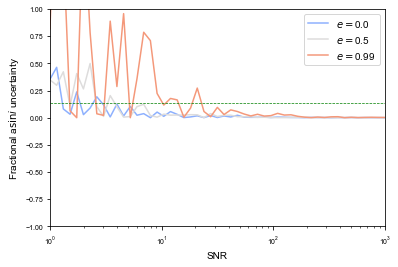

In [32]:
#plt.figure(figsize=mnras_size(240.))
asinis_all_maelstrom = np.array(asinis_all_maelstrom)

from maelstrom.utils import unique_colors
colors = unique_colors(len(eccens), cmap='coolwarm')#[::-1]

for unc, ecc, col in zip(asinis_all_maelstrom, eccens, colors):
    plt.plot(snrs, np.abs((100- unc)/ 100.), label=r'$e=$' + str(ecc), c=col)

plt.axhline(0.136, c='green', linestyle='dashed', linewidth=0.7)

plt.xscale('log')
plt.ylim(-1,1)
plt.xlim(1,1000)

plt.legend()
# plt.text(0.5, 0.5, 'Some Text', ha='center', va='center',rotation='vertical', backgroundcolor='white')

plt.xlabel('SNR')
plt.ylabel(r'Fractional a$\sin{i}$ uncertainty')

In [33]:
# # Fixed parameters
# period_t = 10
# asini_t = 100
# varpi_t = 0.
# tref_t = 0.
# freqs = np.array([50])
# amps = np.array([0.1])
# eccen_t = 0.9
# time = np.arange(0, 27, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs, amps, period_t, eccen_t, asini_t, varpi_t, tref_t)
lc.add_noise(snr=50)

ms = Maelstrom(lc.time, lc.flux, freq=freqs)
a, b = ms.get_time_delay(segment_size=2.)
a += ms.time_mid

td_time_tensor = theano.shared(a)
td_td_tensor = theano.shared(b[:,0])

with pm.Model() as subdivide_model:
    period = pm.Flat("period", testval=period_t)#pm.Uniform("period", lower=1, upper=100, testval=period_t)
    asini = pm.Flat("asini", testval=asini_t)#asini_t#pm.Uniform("asini", lower=0, upper=1000, testval=asini_t)
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux_tensor.get_value())), sd=10, testval=0.)
    eccen = pm.Flat('eccen', testval=eccen_t)#pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=eccen_t)
    omega, phi = 0., 0.
    
    M = 2.0 * np.pi * td_time_tensor / period - phi
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    psi = (1 - tt.square(eccen)) * tt.sin(f+omega) / (1 + eccen*tt.cos(f))

    tau = (asini) * psi

    pm.Normal('obs', mu=tau, 
              sd=tt.exp(logs_lc), 
              observed=td_td_tensor)
    
    fit_params_subdivide = [v for v in subdivide_model.vars if v.name not in ["period", "eccen"]]

In [14]:
def run_fit_subdivide(td_time, td_td, period, asini, eccen):
    with subdivide_model:
        td_time_tensor.set_value(td_time)
        td_td_tensor.set_value(td_td)
        
        start = dict(subdivide_model.test_point)
        start['period'] = period
        start['asini'] = asini
        start['eccen'] = eccen
        
        return xo.optimize(start, vars=fit_params_subdivide, verbose=False)

In [15]:
from tqdm import tqdm

asinis_all_subdivide = []
uncertainties_all_subdivide = []

for eccen in eccens:
    eccen_t = eccen
    lc = SyntheticBinary(time, freqs, amps,
         period_t, eccen_t, asini_t, varpi_t, tref_t)
    
    uncertainties = []
    asinis = []
    # Iterate over each SNR for the given eccentricity
    for snr in tqdm(snrs):
        s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
        np.random.seed(42)
        noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))
        # Run the fit
        ms = Maelstrom(lc.time, noisy_flux, freq=freqs)
        a, b = ms.get_time_delay(segment_size=2.)
        a += ms.time_mid

        opt = run_fit_subdivide(a, b[:,0], period_t, asini_t, eccen_t)
        asinis.append(opt['asini'])
        
        # Get Hessian estimate
#         with subdivide_model:
#             hess = pm.find_hessian(opt, vars=[asini])
#         uncertainties.append(1/np.sqrt(np.abs(np.diag(hess)))[0])
    asinis_all_subdivide.append(asinis)
#     uncertainties_all_subdivide.append(uncertainties)

asinis_all_subdivide = np.array(asinis_all_subdivide)
# uncertainties_all_subdivide = np.array(uncertainties_all_subdivide)

100%|██████████| 51/51 [00:28<00:00,  2.26it/s]


In [18]:
np.savetxt('paper/data/asinis_all_subdivide_10d', asinis_all_subdivide)

In [53]:
asinis_all_subdivide10d = np.loadtxt('paper/data/asinis_all_subdivide_10d')
asinis_all_subdivide100d = np.loadtxt('paper/data/asinis_all_subdivide_100d')
asinis_all_maelstrom10d = np.loadtxt('paper/data/asinis_all_maelstrom_10d')
asinis_all_maelstrom100d = np.loadtxt('paper/data/asinis_all_maelstrom_100d')

# asinis_all_subdivide10d = asinis_all_subdivide10d[:1] + asinis_all_subdivide10d[1:]
# asinis_all_subdivide100d = asinis_all_subdivide100d[:1] + asinis_all_subdivide100d[1:]
# asinis_all_maelstrom10d = asinis_all_maelstrom10d[:1] + asinis_all_maelstrom10d[1:]
# asinis_all_maelstrom100d = asinis_all_maelstrom100d[:1] + asinis_all_maelstrom100d[1:]

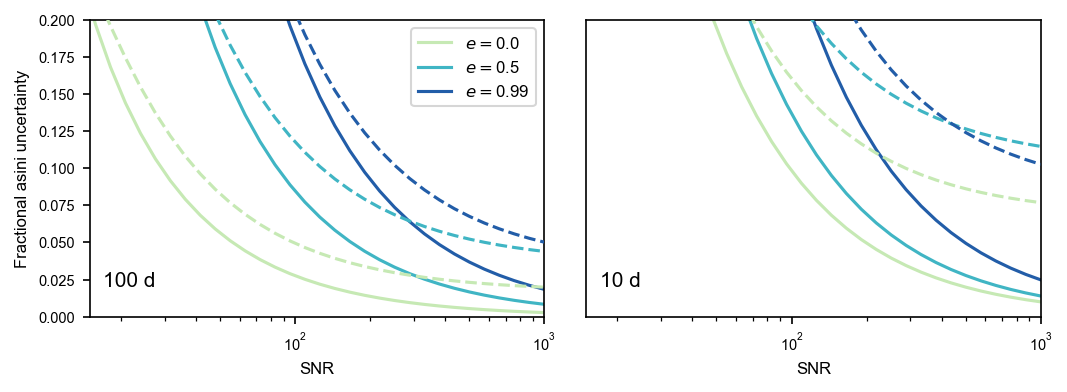

In [55]:
#plt.figure(figsize=mnras_size(240.))
from maelstrom.utils import unique_colors
colors = unique_colors(3, cmap='YlGnBu')

fig, axes = plt.subplots(1,2, figsize=[7,2.5], constrained_layout=True)

ax = axes[0]
for asini_subd, asini_mael, color, eccen in zip(asinis_all_subdivide100d, asinis_all_maelstrom100d, colors, eccens):
    ax.plot(snrs, (100 - asini_subd) / 100, c=color, linestyle='dashed', zorder=5)
    ax.plot(snrs, (100 - asini_mael) / 100, c=color, label=r'$e=$' + str(eccen), zorder=1)
    
ax = axes[1]
for asini_subd, asini_mael, color, eccen in zip(asinis_all_subdivide10d, asinis_all_maelstrom10d, colors, eccens):
    ax.plot(snrs, (100 - asini_subd) / 100, c=color, linestyle='dashed', zorder=5)
    ax.plot(snrs, (100 - asini_mael) / 100, c=color, label=r'$e=$' + str(eccen), zorder=1)
    
axes[0].set_xlim(15,1000)
axes[0].set_ylim(0,0.2)
axes[1].set_xlim(15,1000)
axes[1].set_ylim(0,0.2)

axes[1].set_yticks([])
axes[0].legend(loc=0)

axes[0].set_xscale('log')
axes[1].set_xscale('log')

axes[0].set_xlabel('SNR')
axes[1].set_xlabel('SNR')

axes[0].set_ylabel('Fractional asini uncertainty')

axes[0].text(17,0.02, '100 d', fontsize=10)
axes[1].text(17,0.02, '10 d', fontsize=10)

plt.savefig(overleaf_path + 'comparison.pdf', dpi=300, bbox_inches='tight', pad_inches=0.)

In [37]:
files = lk.search_lightcurvefile('KOI-54', mission='Kepler', cadence='long')

In [50]:
files

SearchResult containing 18 data products.

 target_name            productFilename                        description             distance
------------- ------------------------------------ ----------------------------------- --------
kplr008112039 kplr008112039-2009131105131_llc.fits  Lightcurve Long Cadence (CLC) - Q0      0.0
kplr008112039 kplr008112039-2009166043257_llc.fits  Lightcurve Long Cadence (CLC) - Q1      0.0
kplr008112039 kplr008112039-2009259160929_llc.fits  Lightcurve Long Cadence (CLC) - Q2      0.0
kplr008112039 kplr008112039-2009350155506_llc.fits  Lightcurve Long Cadence (CLC) - Q3      0.0
kplr008112039 kplr008112039-2010078095331_llc.fits  Lightcurve Long Cadence (CLC) - Q4      0.0
kplr008112039 kplr008112039-2010174085026_llc.fits  Lightcurve Long Cadence (CLC) - Q5      0.0
kplr008112039 kplr008112039-2010265121752_llc.fits  Lightcurve Long Cadence (CLC) - Q6      0.0
kplr008112039 kplr008112039-2010355172524_llc.fits  Lightcurve Long Cadence (CLC) - Q7      0

In [49]:
files.target_name

array(['kplr008112039', 'kplr008112039', 'kplr008112039', 'kplr008112039',
       'kplr008112039', 'kplr008112039', 'kplr008112039', 'kplr008112039',
       'kplr008112039', 'kplr008112039', 'kplr008112039', 'kplr008112039',
       'kplr008112039', 'kplr008112039', 'kplr008112039', 'kplr008112039',
       'kplr008112039', 'kplr008112039'], dtype='<U13')

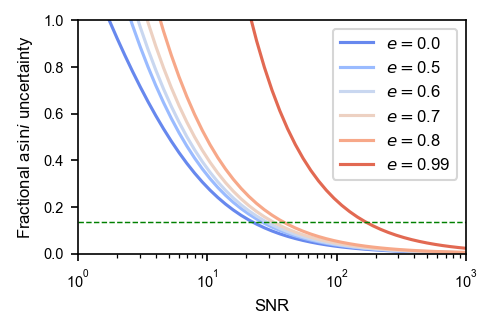

In [363]:
plt.figure(figsize=mnras_size(240.))

from maelstrom.utils import unique_colors
colors = unique_colors(len(eccens), cmap='coolwarm')#[::-1]

for unc, ecc, col in zip(uncertainties_all, eccens, colors):
    plt.plot(snrs, unc/ 100., label=r'$e=$' + str(ecc), c=col)

plt.axhline(0.136, c='green', linestyle='dashed', linewidth=0.7)

plt.xscale('log')
plt.ylim(0,1)
plt.xlim(1,1000)

plt.legend()
# plt.text(0.5, 0.5, 'Some Text', ha='center', va='center',rotation='vertical', backgroundcolor='white')

plt.xlabel('SNR')
plt.ylabel(r'Fractional a$\sin{i}$ uncertainty')

plt.savefig(overleaf_path + 'snr_compare.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

Text(0.5, 0, 'SNR')

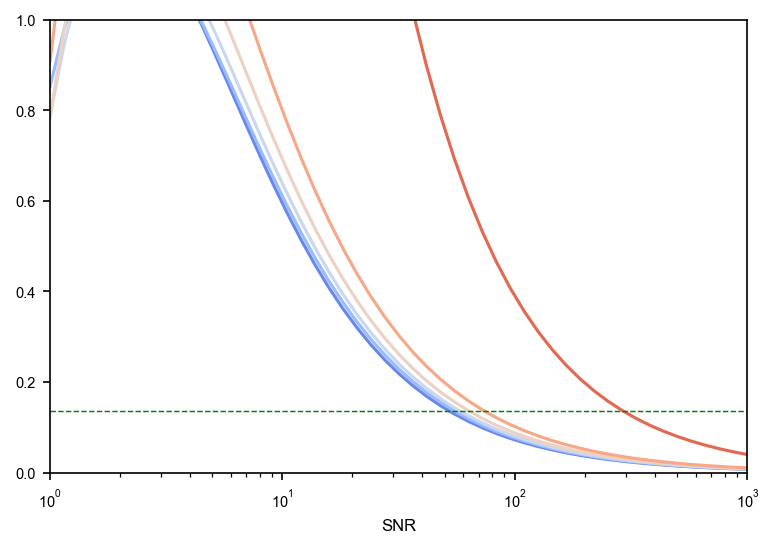

In [361]:
for ass, ecc, col in zip(asinis_all, eccens, colors):
    plt.plot(snrs, (100 - ass) / 100, c=col)

plt.xscale('log')
plt.ylim(0,1)
plt.xlim(1,1000)

plt.axhline(0.136, c='green', linestyle='dashed', linewidth=0.7)
plt.xlabel('SNR')

(0, 1)

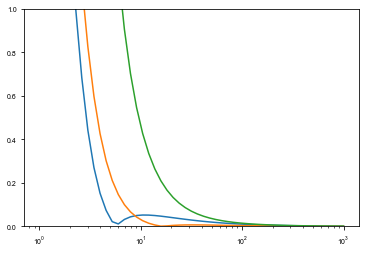

In [200]:
plt.plot(snrs, np.abs((100 -asinis_all.T[:,0])/100))
plt.plot(snrs, np.abs((100 -asinis_all.T[:,1])/100))
plt.plot(snrs, np.abs((100 -asinis_all.T[:,2])/100))

plt.xscale('log')
plt.ylim(0,1)

In [113]:
np.flatten(asinis_all) - asini_t

AttributeError: module 'numpy' has no attribute 'flatten'

In [117]:
np.array(asinis_all) - asini_t

array([[ 20.77596755, -48.36236518, -20.78307535,  -4.05990208,
         -0.73218348]])

In [3]:
from maelstrom.utils import amplitude_spectrum

# Fixed parameters
period_t = 100.
eccen_t = 0.
asini_t = 100
varpi_t = 0.
tref_t = 0.

n_freq = 1
freqs = np.array([50])
amps = np.array([0.1])

# TESS 2 min cadence for 1 sector
time = np.arange(0, 400, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs, amps,
                     period_t, eccen_t, asini_t, varpi_t, tref_t)

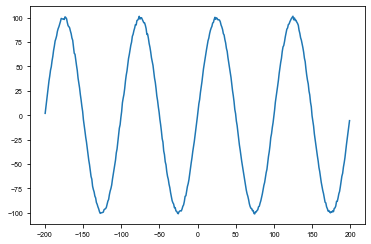

In [4]:
snr = 5000
s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))

ms = Maelstrom(lc.time, noisy_flux, freq=freqs)
td_time, td_td = ms.get_time_delay(segment_size=1)
plt.plot(td_time, td_td)

In [6]:
time_tensor = theano.shared(ms.time)
flux_tensor = theano.shared(ms.flux)
freq = ms.freq

with pm.Model() as model:
    period = period_t#pm.Flat("period", testval=period_t)#pm.Uniform("period", lower=1, upper=100, testval=period_t)
    asini = pm.Flat("asini", testval=asini_t)#asini_t#pm.Uniform("asini", lower=0, upper=1000, testval=asini_t)
    
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux_tensor.get_value())), sd=10, testval=0.)

    # Mean anom
    M = 2.0 * np.pi * time_tensor / period# - phi
    psi = tt.sin(M)
    
    """nu = freq
    factor = 2. * np.pi * nu
    arg = ((factor)[None, :] * time_tensor[:, None] - (factor * asini / 86400)[None, :] * psi[:, None])

    phase = xo.distributions.Angle("phase", shape=len(freq))
    log_mean_amp = np.log(1.)
    logamp = pm.Normal("logamp", mu=log_mean_amp, sd=1.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)

    full_lc = lc_model# + mean"""
    
    # tau in d
    tau = (asini) * psi[:,None]
    tau /= 86400.

    arg = 2. * np.pi * freq[None, :] * (time_tensor[:,None] - tau)
    D = tt.concatenate([tt.cos(arg), tt.sin(arg)],axis=1)
    DTD = tt.dot(D.T,D)
    DTy = tt.dot(D.T, flux_tensor[:, None])
    W_hat = tt.slinalg.solve(DTD, DTy)
    model_tensor = tt.squeeze(tt.dot(D,W_hat))

    pm.Normal('obs', mu=model_tensor, 
              sd=tt.exp(logs_lc), 
              observed=flux_tensor)
    

In [8]:
from tqdm import tqdm

snrs = np.geomspace(1,1000,20) 
uncertainties = []     
for snr in tqdm(snrs):
    s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
    np.random.seed(42)
    noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))

    ms = Maelstrom(lc.time, noisy_flux, freq=freqs)
    time, flux = ms.time, ms.flux
    
    with model:
        time_tensor.set_value(time)
        flux_tensor.set_value(flux)
        map_params = pm.find_MAP(progressbar=False)
        #map_params = {'period':np.array(period_t)}
        hess = pm.find_hessian(map_params, vars=[asini])
        uncertainties.append(1/np.sqrt(np.abs(np.diag(hess))))
        
uncertainties = np.array(uncertainties)

  0%|          | 0/20 [00:00<?, ?it/s]/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')


KeyboardInterrupt: 

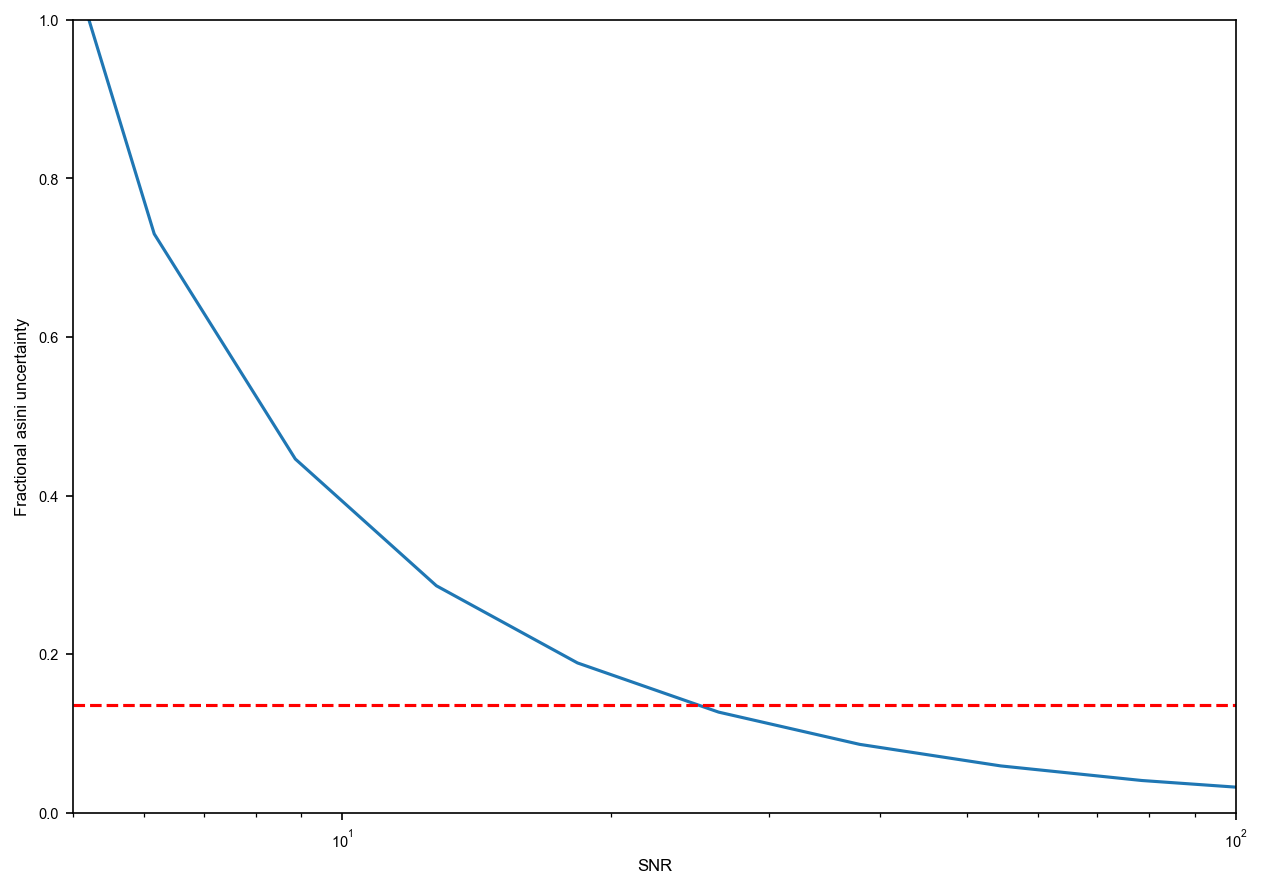

In [79]:
plt.figure(figsize=[10,7])
plt.plot(snrs, uncertainties / asini_t)
#plt.yscale('log')
plt.xscale('log')
plt.ylim(0,1.)
plt.xlim(5,100)

plt.xlabel('SNR')
plt.ylabel('Fractional asini uncertainty')

plt.axhline(0.136, c='r', linestyle='dashed')

# ECCENTRIC MODEL

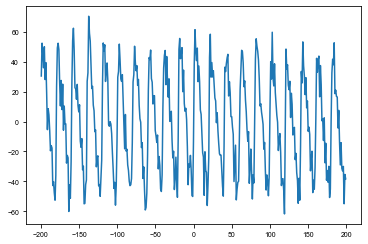

In [5]:
from maelstrom.utils import amplitude_spectrum

# Fixed parameters
period_t = 20.
eccen_t = 0.9
asini_t = 100
varpi_t = 0.
tref_t = 0.

n_freq = 1
freqs = np.array([50])
amps = np.array([0.1])

# TESS 2 min cadence for 1 sector
time = np.arange(0, 400, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs, amps,
                     period_t, eccen_t, asini_t, varpi_t, tref_t)

snr = 500
s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))

ms = Maelstrom(lc.time, noisy_flux, freq=freqs)
td_time, td_td = ms.get_time_delay(segment_size=1)
plt.plot(td_time, td_td)

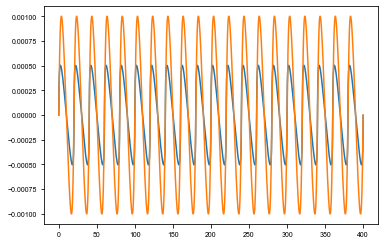

In [10]:
time_tensor = theano.shared(ms.time)
flux_tensor = theano.shared(ms.flux)
freq = ms.freq

with pm.Model() as model:
    period = period_t#pm.Flat("period", testval=period_t)#pm.Uniform("period", lower=1, upper=100, testval=period_t)
    asini = pm.Flat("asini", testval=asini_t)#asini_t#pm.Uniform("asini", lower=0, upper=1000, testval=asini_t)
    
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux_tensor.get_value())), sd=10, testval=0.)

    # Mean anom
    M = 2.0 * np.pi * time_tensor / period# - phi
    omega = 0. #xo.distributions.Angle("omega")
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.999, testval=0.5)
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(time)))
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    
    # tau in d
    tau = (asini) * psi[:,None]
    tau /= 86400.
    
    arg = 2. * np.pi * freq[None, :] * (time_tensor[:,None] - tau)
    D = tt.concatenate([tt.cos(arg), tt.sin(arg)],axis=1)
    DTD = tt.dot(D.T,D)
    DTy = tt.dot(D.T, flux_tensor[:, None])
    W_hat = tt.slinalg.solve(DTD, DTy)
    model_tensor = tt.squeeze(tt.dot(D,W_hat))

    pm.Normal('obs', mu=model_tensor, 
              sd=tt.exp(logs_lc), 
              observed=flux_tensor)
    
    plt.plot(lc.time, lc.tau)
    plt.plot(lc.time, xo.eval_in_model(tau))

In [113]:
with model:
    map_p = pm.find_MAP()



  0%|          | 0/5000 [00:00<?, ?it/s]

logp = -1.3234e+10, ||grad|| = 2.6467e+10:   0%|          | 0/5000 [00:00<?, ?it/s]

logp = -1.3234e+10, ||grad|| = 2.6467e+10:   0%|          | 1/5000 [00:00<17:33,  4.75it/s]

logp = -1.3234e+10, ||grad|| = 2.6467e+10:   0%|          | 2/5000 [00:00<17:14,  4.83it/s]

logp = -1.3234e+10, ||grad|| = 2.6467e+10:   0%|          | 3/5000 [00:00<17:04,  4.88it/s]

logp = -1.3234e+10, ||grad|| = 2.6467e+10:   0%|          | 4/5000 [00:00<17:30,  4.76it/s]

logp = -1.3234e+10, ||grad|| = 2.6467e+10:   0%|          | 5/5000 [00:01<17:32,  4.75it/s]

logp = -1.3234e+10, ||grad|| = 2.6467e+10:   0%|          | 6/5000 [00:01<16:58,  4.90it/s]

logp = -1.3234e+10, ||grad|| = 2.6467e+10:   0%|          | 7/5000 [00:01<16:45,  4.97it/s]

logp = -1.3234e+10, ||grad|| = 2.6467e+10:   0%|          | 8/5000 [00:01<16:40,  4.99it/s]

logp = -1.3234e+10, ||grad|| = 2.6467e+10:   0%|          | 9/5000 [00:01<16:35,  5.01it/s]

logp = -1.3234e+10, ||grad|| = 2.6

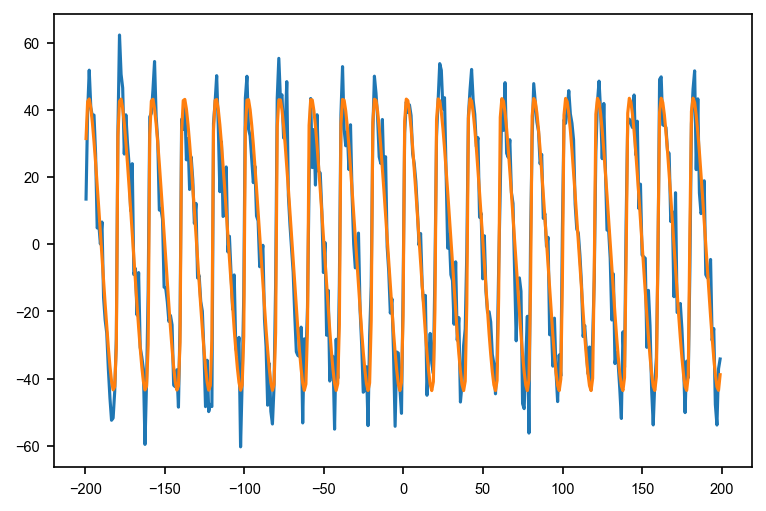

In [172]:
time_tensor = theano.shared(td_time)
flux_tensor = theano.shared(td_td)
freq = ms.freq

with pm.Model() as model:
    period = period_t#pm.Flat("period", testval=period_t)#pm.Uniform("period", lower=1, upper=100, testval=period_t)
    asini = pm.Flat("asini", testval=asini_t)#asini_t#pm.Uniform("asini", lower=0, upper=1000, testval=asini_t)
    #logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux_tensor.get_value())), sd=10, testval=0.)

    # Mean anom
    M = 2.0 * np.pi * time_tensor / period# - phi
    omega = 0.
    # Eccentricity
    eccen = pm.Flat('eccen', testval=0.9)#pm.Uniform("eccen", lower=0, upper=0.999, testval=0.5)
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(time_tensor.get_value())))
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    
    # tau in d
    tau = (asini) * psi[:,None]
    
    pm.Normal('obs', mu=tau, 
              #sd=tt.exp(logs_lc), 
              observed=flux_tensor)
    
    plt.plot(td_time, td_td)
    plt.plot(td_time, xo.eval_in_model(tau))

In [173]:
with model:
    opt = pm.find_MAP()
opt

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')


  0%|          | 0/5000 [00:00<?, ?it/s]

logp = -15,883, ||grad|| = 18,464:   0%|          | 0/5000 [00:00<?, ?it/s]

logp = -15,883, ||grad|| = 18,464:   0%|          | 1/5000 [00:00<01:42, 48.85it/s]

ValueError: eccentricity must be 0 <= e < 1
Apply node that caused the error: KeplerOp(Elemwise{mul,no_inplace}.0, Alloc.0)
Toposort index: 5
Inputs types: [TensorType(float64, vector), TensorType(float64, vector)]
Inputs shapes: [(399,), (399,)]
Inputs strides: [(8,), (8,)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[InplaceDimShuffle{0,x}(KeplerOp.0)], [InplaceDimShuffle{0,x}(KeplerOp.1)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/danielhey/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2880, in _run_cell
    return runner(coro)
  File "/Users/danielhey/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/danielhey/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/danielhey/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/danielhey/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-172-a1b0f8cb6c86>", line 16, in <module>
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(time_tensor.get_value())))
  File "/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/gof/op.py", line 615, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/Users/danielhey/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/kepler/kepler.py", line 39, in make_node
    return gof.Apply(self, in_args, [in_args[0].type(), in_args[0].type()])

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [161]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eccen, asini]


Sampling 2 chains:   0%|          | 0/3000 [00:00<?, ?draws/s]

Sampling 2 chains:   3%|▎         | 78/3000 [00:00<00:03, 777.34draws/s]

Sampling 2 chains:   3%|▎         | 102/3000 [00:00<00:09, 303.04draws/s]

Sampling 2 chains:   4%|▍         | 123/3000 [00:00<00:11, 251.11draws/s]

Sampling 2 chains:   5%|▍         | 143/3000 [00:00<00:12, 224.02draws/s]

Sampling 2 chains:   5%|▌         | 162/3000 [00:00<00:14, 201.89draws/s]

Sampling 2 chains:   7%|▋         | 205/3000 [00:00<00:11, 239.22draws/s]

Sampling 2 chains:   8%|▊         | 237/3000 [00:00<00:10, 258.17draws/s]

Sampling 2 chains:   9%|▉         | 269/3000 [00:00<00:10, 268.46draws/s]

Sampling 2 chains:  10%|▉         | 297/3000 [00:01<00:11, 243.43draws/s]

Sampling 2 chains:  11%|█         | 333/3000 [00:01<00:09, 269.59draws/s]

Sampling 2 chains:  12%|█▏        | 362/3000 

In [162]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
asini,81.826079,0.632962,0.025836,80.701932,83.092621,491.244323,1.001507
eccen,0.849956,0.002455,0.000101,0.845350,0.854711,494.977229,1.001219


In [174]:
with model:
    hess = pm.find_hessian({'asini': np.array(asini_t),
                           'eccen': np.array(0.9)}, vars=[asini, eccen])

In [175]:
1/np.sqrt(np.diag(hess))

array([0.16247593, 0.00034451])

In [168]:
opt

{'asini': array(81.79398832),
 'eccen_interval__': array(1.74009725),
 'eccen': array(0.84984872)}

In [6]:
from maelstrom.utils import amplitude_spectrum



  0%|          | 0/100 [00:00<?, ?it/s]/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  1%|          | 1/100 [00:18<30:42, 18.61s/it]/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  3%|▎         | 3/100 [00:35<21:28, 13.28s/it]

KeyboardInterrupt: 

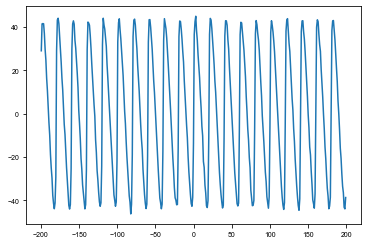

In [7]:
snr = 5000
s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))

ms = Maelstrom(lc.time, noisy_flux, freq=freqs)
td_time, td_td = ms.get_time_delay(segment_size=1)
plt.plot(td_time, td_td)

time_tensor = theano.shared(ms.time)
flux_tensor = theano.shared(ms.flux)
freq = ms.freq

with pm.Model() as model:
    period = period_t#pm.Flat("period", testval=period_t)#pm.Uniform("period", lower=1, upper=100, testval=period_t)
    asini = pm.Flat("asini", testval=asini_t)#asini_t#pm.Uniform("asini", lower=0, upper=1000, testval=asini_t)
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux_tensor.get_value())), sd=10, testval=0.)
    
    # Mean anom
    M = 2.0 * np.pi * time_tensor / period# - phi
    psi = tt.sin(M)
    
    # tau in d
    tau = (asini) * psi[:,None]
    tau /= 86400.

    arg = 2. * np.pi * freq[None, :] * (time_tensor[:,None] - tau)
    D = tt.concatenate([tt.cos(arg), tt.sin(arg)],axis=1)
    DTD = tt.dot(D.T,D)
    DTy = tt.dot(D.T, flux_tensor[:, None])
    W_hat = tt.slinalg.solve(DTD, DTy)
    model_tensor = tt.squeeze(tt.dot(D,W_hat))

    pm.Normal('obs', mu=model_tensor, 
              sd=tt.exp(logs_lc), 
              observed=flux_tensor)
    
from tqdm import tqdm

snrs = np.geomspace(1,1000,100) 
vvals = []

eccens = [0.,0.5, 0.9]
for eccen in eccens:
    
    # Fixed parameters
    period_t = 100
    eccen_t = eccen
    asini_t = 100
    varpi_t = 0.
    tref_t = 0.
    freqs = np.array([50])
    amps = np.array([0.1])

    # TESS 2 min cadence for 1 sector
    time = np.arange(0, 400, 1.0 / (24 * 30))

    lc = SyntheticBinary(time, freqs, amps,
                         period_t, eccen_t, asini_t, varpi_t, tref_t)
    
    uncertainties = []  
    for snr in tqdm(snrs):
        s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
        np.random.seed(42)
        noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))

        ms = Maelstrom(lc.time, noisy_flux, freq=freqs)
        time, flux = ms.time, ms.flux

        with model:
            time_tensor.set_value(time)
            flux_tensor.set_value(flux)
            map_params = pm.find_MAP(progressbar=False)
            #map_params = {'period':np.array(period_t)}
            hess = pm.find_hessian(map_params, vars=[asini])
            uncertainties.append(1/np.sqrt(np.abs(np.diag(hess))))
            
    vvals.append(uncertainties) 
#uncertainties1 = np.array(uncertainties1)

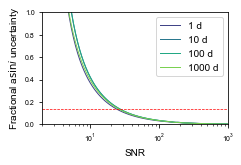

In [11]:
plt.figure(figsize=mnras_size(240.))

from maelstrom.utils import unique_colors
hh = unique_colors(4, cmap='viridis')

snrs = np.geomspace(1,1000,100) 
vvals = np.loadtxt('paper/data/snr_compare_results.txt')
plt.plot(snrs, np.array(vvals[0]) / asini_t, label='1 d', c=hh[0], linewidth=1)
plt.plot(snrs, np.array(vvals[1]) / asini_t, label='10 d', c=hh[1], linewidth=1)
plt.plot(snrs, np.array(vvals[2]) / asini_t, label='100 d', c=hh[2], linewidth=1)
plt.plot(snrs, np.array(vvals[3]) / asini_t, label='1000 d', c=hh[3], linewidth=1)
plt.xscale('log')

plt.ylim(0,1.)
plt.xlim(2,1000)
plt.xlabel('SNR')
plt.ylabel(r'Fractional a$\sin{i}$ uncertainty')

plt.axhline(0.136, c='red', linestyle='dashed', linewidth=0.7)
plt.legend(loc='upper right')
#plt.savefig(overleaf_path + 'snr_compare.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [128]:
np.savetxt('paper/data/snr_compare_results.txt', np.reshape(vvals, (4,100)))

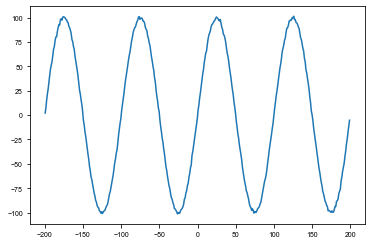

In [34]:
from maelstrom.utils import amplitude_spectrum

# Fixed parameters
period_t = 100.
eccen_t = 0.
asini_t = 100
varpi_t = 0.
tref_t = 0.

n_freq = 1
freqs = np.array([50])
amps = np.array([0.1])

# TESS 2 min cadence for 1 sector
time = np.arange(0, 400, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs, amps,
                     period_t, eccen_t, asini_t, varpi_t, tref_t)


snr = 5000
s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))

ms = Maelstrom(lc.time, noisy_flux, freq=freqs)
td_time, td_td = ms.get_time_delay(segment_size=1)
plt.plot(td_time, td_td)

In [54]:
td_time_tensor = theano.shared(td_time)
td_td_tensor = theano.shared(td_td)

with pm.Model() as subdivide_model:
    # Parameters
    period = period_t#pm.Flat('period', testval=period_t)#period_t#pm.Uniform("period", lower=1, upper=100, testval=period_t)
    asini = pm.Flat('asini', testval=asini_t)#pm.Uniform("asini", lower=0, upper=1000, testval=asini_t)
    logs_lc = pm.Normal('logs_lc', mu=0., sd=10, testval=0.)
    
    # Mean anom
    M = 2.0 * np.pi * td_time_tensor / period
    # True anom
    psi = tt.sin(M)
    # tau in d
    tau = (asini)* psi[:,None]
    
    # Condition on the observations
    pm.Normal("obs", mu=tau, 
              sd=tt.exp(logs_lc), 
              observed=td_td_tensor)

In [63]:
from tqdm import tqdm_notebook as tqdm

snrs = np.geomspace(1,1000,100) 
uncertainties_subd = []    

for snr in tqdm(snrs):
    s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
    np.random.seed(42)
    noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))
    ms = Maelstrom(lc.time, noisy_flux, freq=freqs)
    td_time, td_td = ms.get_time_delay(segment_size=10)
    
    with subdivide_model:
        td_time_tensor.set_value(td_time)
        td_td_tensor.set_value(td_td)
        map_params = xo.optimize(verbose=False)#pm.find_MAP(progressbar=False)
        hess = pm.find_hessian(map_params, vars=[asini])
        uncertainties_subd.append(1/np.sqrt(np.abs(np.diag(hess))))
        
uncertainties_subd = np.array(uncertainties_subd)

(0, 1)

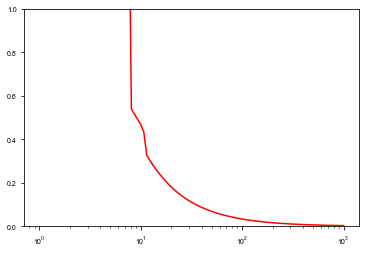

In [64]:
#plt.scatter(snrs, uncertainties[:,0])
#plt.scatter(snrs, uncertainties_subd[:,1] /asini_t, c='r')
plt.plot(snrs, uncertainties_subd / asini_t, c='r')
plt.xscale('log')
#plt.yscale('log')
plt.ylim(0,1)

In [65]:
snrs_subd = snrs


In [29]:
uncertainties_subd[:,0]


array([0.71127155, 0.31833128, 0.3975015 , 0.38429699, 0.53682349,
       0.46589315, 0.24647192, 0.33234415, 1.88500727, 0.11222288,
       0.40770338, 0.38067988, 0.30851457, 0.39284387, 0.30890215,
       0.42491753, 0.17556441, 1.65987529, 1.21968408, 0.32268047,
       0.34490644, 0.07596131, 0.42951787, 0.23658475, 0.37927036,
       0.19003232, 0.1712976 , 0.40919897, 0.56431947, 0.71084261,
       0.13538439, 0.40048513, 0.39895537, 0.22191119, 1.22163453,
       0.39533434, 0.01874465, 0.0832747 , 0.01461891, 0.01473523,
       0.23210048, 0.01372434, 0.01267139, 0.01097817, 0.00910026,
       0.00827733, 0.00824651, 0.00686353, 0.00634225, 0.00578761])

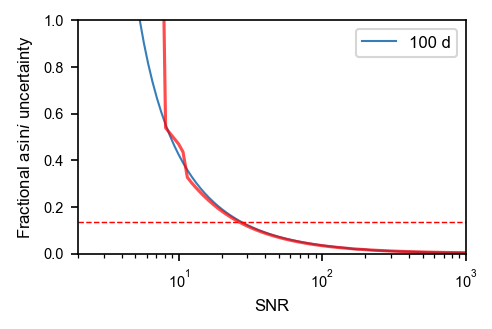

In [71]:
plt.figure(figsize=mnras_size(240.))

from maelstrom.utils import unique_colors
hh = unique_colors(4, cmap='viridis')

snrs = np.geomspace(1,1000,100) 
vvals = np.loadtxt('paper/data/snr_compare_results.txt')
#plt.plot(snrs, np.array(vvals[0]) / asini_t, label='1 d', c=hh[0], linewidth=1)
#plt.plot(snrs, np.array(vvals[1]) / asini_t, label='10 d', c=hh[1], linewidth=1)
plt.plot(snrs, np.array(vvals[2]) / asini_t, label='100 d', c=blue, linewidth=1)
plt.plot(snrs_subd, uncertainties_subd / asini_t, c='r', alpha=0.7)
#plt.plot(snrs, np.array(vvals[3]) / asini_t, label='1000 d', c=hh[3], linewidth=1)
plt.xscale('log')

plt.ylim(0,1.)
plt.xlim(2,1000)
plt.xlabel('SNR')
plt.ylabel(r'Fractional a$\sin{i}$ uncertainty')

plt.axhline(0.136, c='red', linestyle='dashed', linewidth=0.7)
plt.legend(loc='upper right')
#plt.savefig(overleaf_path + 'snr_compare.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [29]:
from maelstrom.utils import amplitude_spectrum

# Fixed parameters
period_t = 10.
eccen_t = 0.
asini_t = 100
varpi_t = 1.
tref_t = 0.

n_freq = 1
freqs = np.array([50])
amps = np.array([0.1])

# TESS 2 min cadence for 1 sector
time = np.arange(0, 27, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs, amps,
                     period_t, eccen_t, asini_t, varpi_t, tref_t)

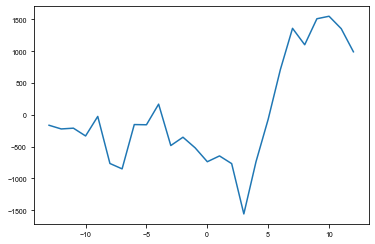

In [34]:
snr = 4
s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))

ms = Maelstrom(lc.time, noisy_flux, freq=freqs)
td_time, td_td = ms.get_time_delay(segment_size=1)
plt.plot(td_time, td_td)

time, flux = ms.time, ms.flux

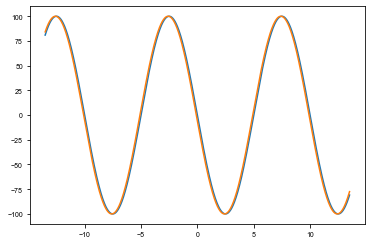

In [35]:

with pm.Model() as model:
    #logP = pm.Normal("logP", mu=np.log(period_t), sd=1.0, testval=np.log(period_t))
    period = pm.Flat("period", testval=period_t)
    asini = asini_t
    
    # Mean anom
    M = 2.0 * np.pi * time / period# - phi
    psi = -tt.sin(M)
    # tau in d
    tau = (asini) * psi[:,None]
    tau /= 86400.

    arg = 2. * np.pi * freqs[None, :] * (time[:,None] - tau)
    D = tt.concatenate([tt.cos(arg), tt.sin(arg)],axis=1)
    DTD = tt.dot(D.T,D)
    DTy = tt.dot(D.T, flux[:, None])
    W_hat = tt.slinalg.solve(DTD, DTy)

    model_tensor = tt.squeeze(tt.dot(D,W_hat))
    
    full_lc = model_tensor# + mean
    
    pm.Normal('obs', mu=full_lc, sd=None, observed=flux)
    
with model:
    plt.plot(time, xo.eval_in_model(asini * psi))
    plt.plot(time, lc.tau * 86400)

In [36]:
with model:
    hess = pm.find_hessian({'period':np.array(12.)})

In [37]:
np.diagonal((1/np.abs(hess))**0.5)

array([0.00129919])

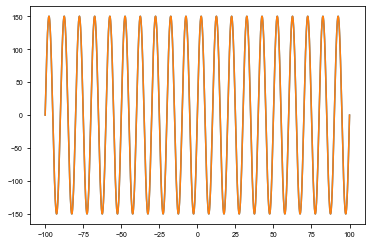

In [60]:

with pm.Model() as model:
    #logP = pm.Normal("logP", mu=np.log(period_t), sd=1.0, testval=np.log(period_t))
    period = pm.Uniform("period", lower=1, upper=100, testval=period_t)
    asini = pm.Uniform("asini", lower=0, upper=1000, testval=asini_t)
    
    # The time of conjunction
    #phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    
    # Mean anom
    M = 2.0 * np.pi * time / period# - phi
    psi = tt.sin(M)
    nu = freq
    factor = 2. * np.pi * nu
    arg = ((factor)[None, :] * time[:, None] - (factor * asini / 86400)[None, :] * psi[:, None])

    phase = xo.distributions.Angle("phase", shape=len(freq))
    #log_mean_amp = 0.5*(log_min_amp + log_max_amp)
    log_mean_amp = np.log(weights)
    logamp = pm.Normal("logamp", mu=log_mean_amp, sd=1.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
    
    full_lc = lc_model# + mean
    
    pm.Normal('obs', mu=full_lc, sd=tt.exp(logs_lc), observed=flux)
    
with model:
    
    plt.plot(time, xo.eval_in_model(asini * psi))
    plt.plot(time, lc.tau * 86400)

In [61]:
with model:
    map_params = pm.find_MAP()
    print(map_params)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -9.7768e+05, ||grad|| = 1.4841: 100%|██████████| 42/42 [00:00<00:00, 66.06it/s]      

{'period_interval__': array(-2.30249749), 'asini_interval__': array(-1.73648775), 'logs_lc': array(5.37038032), 'phase_angle__': array([[0.2129448],
       [0.9827305]]), 'logamp': array([4.60210027]), 'period': array(10.00071678), 'asini': array(149.75960499), 'phase': array([0.21338795])}


In [62]:
with model:
    pm.find_hessian()

{'period_interval__': array(-2.30249749),
 'asini_interval__': array(-1.73648775),
 'logs_lc': array(5.37038032),
 'phase_angle__': array([[0.2129448],
        [0.9827305]]),
 'logamp': array([4.60210027]),
 'period': array(10.00071678),
 'asini': array(149.75960499),
 'phase': array([0.21338795])}

In [397]:
with model:
    hess = pm.find_hessian(map_params, vars=[period, asini])
1/np.sqrt(np.abs(np.diag(hess)))

array([0.00011411, 0.0621309 ])

# Subdivide

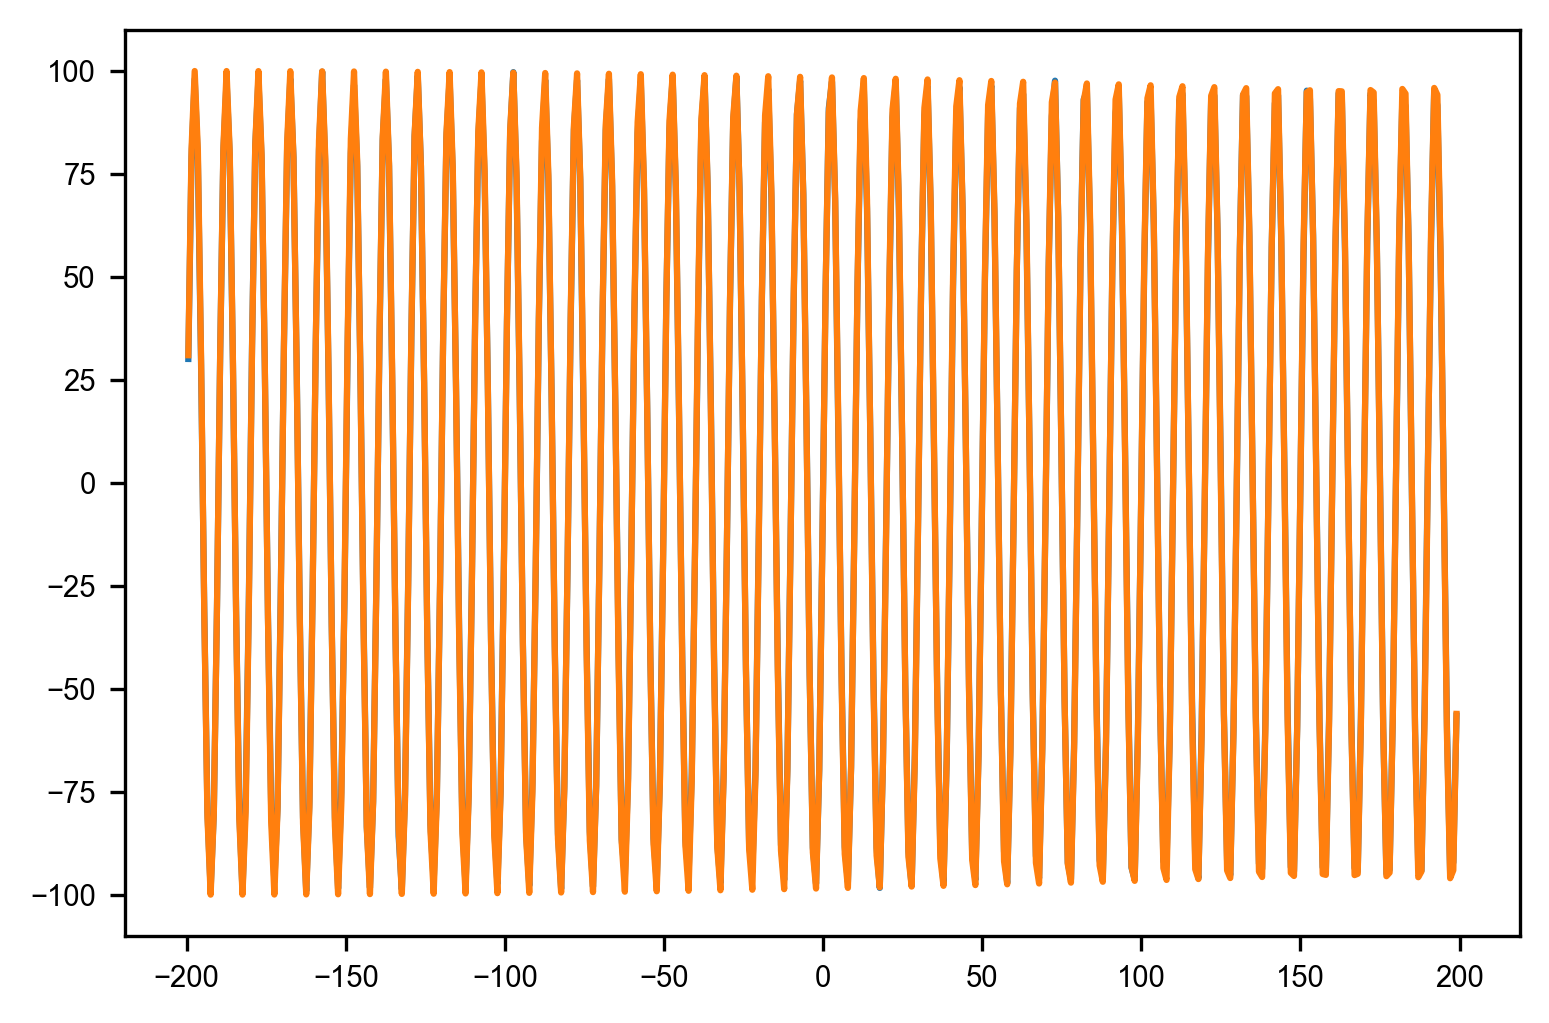

In [159]:
import theano.tensor as tt
import theano
from exoplanet.orbits import get_true_anomaly

td_time_tensor = theano.shared(td_time)
td_td_tensor = theano.shared(td_td)

with pm.Model() as subdivide_model:
    # Parameters
    period = pm.Uniform("period", lower=1, upper=100, testval=period_t)
    asini = pm.Flat('asini', testval=asini_t)#pm.Uniform("asini", lower=0, upper=1000, testval=asini_t)
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    
    # Mean anom
    M = 2.0 * np.pi * td_time_tensor / period# - phi
    # True anom
    psi = tt.sin(M)
    # tau in d
    tau = (asini)* psi[:,None]
    #tau /= 86400.
    
    # Condition on the observations
    pm.Normal("obs", mu=tau, sd=tt.exp(logs_lc), observed=td_td_tensor)
    
    plt.plot(td_time, td_td)
    plt.plot(td_time, xo.eval_in_model(tau))

In [160]:
with subdivide_model:
    map_p = pm.find_MAP()
    print(map_p)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')


  0%|          | 0/5000 [00:00<?, ?it/s]

logp = -813.03, ||grad|| = 34,332:   0%|          | 0/5000 [00:00<?, ?it/s]

logp = -812.8, ||grad|| = 40,127:   0%|          | 10/5000 [00:00<00:05, 868.82it/s]

logp = -716.47, ||grad|| = 312.46:   0%|          | 20/5000 [00:00<00:04, 1077.89it/s]

logp = -694.38, ||grad|| = 1,725.8:   1%|          | 30/5000 [00:00<00:04, 1209.44it/s]

logp = -672.12, ||grad|| = 3.0293e+05:   1%|          | 40/5000 [00:00<00:04, 1200.98it/s]

logp = -544.09, ||grad|| = 53.196:   1%|          | 50/5000 [00:00<00:04, 1181.39it/s]    

logp = -544.09, ||grad||

{'period_interval__': array(-2.30257818), 'asini': array(98.3657191), 'logs_lc': array(-0.07508557), 'period': array(10.00005655)}


In [161]:
with subdivide_model:
    hess = pm.find_hessian(map_p, vars=[period, asini])
1/np.sqrt(np.abs(np.diag(hess)))

array([9.23095476e-05, 6.56404694e-02])